# Analyzing the UCI heart disease dataset

The UCI repository contains three datasets on heart disease.   Each dataset contains information about several patients suspected of having heart disease such as  whether or not the patient is a smoker, the patients resting heart rate, age, sex, etc.   The patients were all tested for heart disease and the results of that tests are given as numbers ranging from 0 (no heart disease) to 4 (severe heart disease).   The goal of this notebook will be to use machine learning and statistical techniques to see if we can predict both the presense and severity of heart disease from the features given.   In addition, we will also analyze which features are most important in predicting the presense and severity of heart disease.  

There are three relevent datasets we will be using, which are from Hungary, Long Beach, and Cleveland.  Each of these hospitals recorded patient data, which was published with personal information removed from the database.   

## Table of Contents:

* [Cleaning the data](#1)
    * [removing currupted data](#1.1)
    * [filling in NaN](#1.2)
    * [removing non-predictive features](#1.3)
    * [encoding categorical features](#1.4)
* [Exploratory data analysis](#2)
    * [Selecting features](#2.1)
    * [Applying ML algorithms](#2.2)
* [Testing the model](#3)
* [Conclusions](#4)

## Cleaning the Data <a id ='1'></a>

The datasets are slightly messy and will first need to be cleaned.  For example,the dataset isn't in standard csv format, instead each feature spans several lines, with each feature being seperated by the word 'name'.   We will first process the data to bring it into csv format, and then import it into a pandas df.  The names and discriptions of the features, found on the UCI repository is stored in the string feature_names.   

In [1]:
%matplotlib inline
import xgboost as xgb
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\Michael\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import urllib
import re
#found on UCI database.
feature_names = '''1 id: patient identification number
      2 ccf: social security number (I replaced this with a dummy value of 0)
      3 age: age in years
      4 sex: sex (1 = male; 0 = female)
      5 painloc: chest pain location (1 = substernal; 0 = otherwise)
      6 painexer (1 = provoked by exertion; 0 = otherwise)
      7 relrest (1 = relieved after rest; 0 = otherwise)
      8 pncaden (sum of 5, 6, and 7)
      9 cp: chest pain type
     10 trestbps: resting blood pressure (in mm Hg on admission to the hospital)
     11 htn
     12 chol: serum cholestoral in mg/dl
     13 smoke: I believe this is 1 = yes; 0 = no (is or is not a smoker)
     14 cigs (cigarettes per day)
     15 years (number of years as a smoker)
     16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
     17 dm (1 = history of diabetes; 0 = no such history)
     18 famhist: family history of coronary artery disease (1 = yes; 0 = no)
     19 restecg: resting electrocardiographic results
     20 ekgmo (month of exercise ECG reading)
     21 ekgday (day of exercise ECG reading)
     22 ekgyr (year of exercise ECG reading)
     23 dig (digitalis used furing exercise ECG: 1 = yes; 0 = no)
     24 prop (Beta blocker used during exercise ECG: 1 = yes; 0 = no)
     25 nitr (nitrates used during exercise ECG: 1 = yes; 0 = no)
     26 pro (calcium channel blocker used during exercise ECG: 1 = yes; 0 = no)
     27 diuretic (diuretic used used during exercise ECG: 1 = yes; 0 = no)
     28 proto: exercise protocol
     29 thaldur: duration of exercise test in minutes
     30 thaltime: time when ST measure depression was noted
     31 met: mets achieved
     32 thalach: maximum heart rate achieved
     33 thalrest: resting heart rate
     34 tpeakbps: peak exercise blood pressure (first of 2 parts)
     35 tpeakbpd: peak exercise blood pressure (second of 2 parts)
     36 dummy
     37 trestbpd: resting blood pressure
     38 exang: exercise induced angina (1 = yes; 0 = no)
     39 xhypo: (1 = yes; 0 = no)
     40 oldpeak = ST depression induced by exercise relative to rest
     41 slope: the slope of the peak exercise ST segment
     42 rldv5: height at rest
     43 rldv5e: height at peak exercise
     44 ca: number of major vessels (0-3) colored by flourosopy
     45 restckm: irrelevant
     46 exerckm: irrelevant
     47 restef: rest raidonuclid (sp?) ejection fraction
     48 restwm: rest wall (sp?) motion abnormality
     49 exeref: exercise radinalid (sp?) ejection fraction
     50 exerwm: exercise wall (sp?) motion 
     51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
     52 thalsev: not used
     53 thalpul: not used
     54 earlobe: not used
     55 cmo: month of cardiac cath (sp?)  (perhaps "call")
     56 cday: day of cardiac cath (sp?)
     57 cyr: year of cardiac cath (sp?)
     58 num: diagnosis of heart disease 
     59 lmt
     60 ladprox
     61 laddist
     62 diag
     63 cxmain
     64 ramus
     65 om1
     66 om2
     67 rcaprox
     68 rcadist
     69 lvx1: not used
     70 lvx2: not used
     71 lvx3: not used
     72 lvx4: not used
     73 lvf: not used
     74 cathef: not used
     75 junk: not used '''
name_cols = []
for line in feature_names.split('\n'):
    name_cols.append(line.strip().split()[1].strip(': '))
file1=io.TextIOWrapper(urllib.request.urlopen(
    'http://mlr.cs.umass.edu/ml/machine-learning-databases/heart-disease/cleveland.data'),encoding='ISO-8859-1')
file2=io.TextIOWrapper(urllib.request.urlopen(
    'http://mlr.cs.umass.edu/ml/machine-learning-databases/heart-disease/hungarian.data'),encoding='ISO-8859-1')
file3=io.TextIOWrapper(urllib.request.urlopen(
     'http://mlr.cs.umass.edu/ml/machine-learning-databases/heart-disease/long-beach-va.data'),encoding='ISO-8859-1')
outer_list = []
inner_list = []
for file_ in (file1,file2,file3):
    for line in file_:
        quantities = re.split('[^0-9.name-]+',line.strip())
        for x in quantities:
            if x!='name':
                inner_list.append(x)
            else:
                outer_list.append(inner_list)
                inner_list=[]

### Removing currupted data: <a id='1.1'></a>
The data should have 75 rows, however, several of the rows were not written correctly and instead have too many elements.  These rows will be deleted, and the data will then be loaded into a pandas dataframe.  

In [3]:
for i,row in enumerate(outer_list):
    if len(row)!=75:
        print(len(row),i)
print(inner_list)

252 282
431 283
9 284
1 285
25 286
1 287
14 288
160 289
45 290
218 291
2 292
145 293
76 587
['']


In [4]:
removeable_rows = sorted([i for i,row in enumerate(outer_list) if len(row)!=75],reverse=True)
for i in removeable_rows:
    del outer_list[i]
df = pd.DataFrame(outer_list,columns=name_cols)
df.head()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk
0,1,0,63,1,-9,-9,-9,-9,1,145,...,-9,1,1,1,1,1,1,1,-9,-9
1,2,0,67,1,-9,-9,-9,-9,4,160,...,-9,1,1,1,1,1,1,1,-9,-9
2,3,0,67,1,-9,-9,-9,-9,4,120,...,-9,2,2,1,1,1,7,3,-9,-9
3,4,0,37,1,-9,-9,-9,-9,3,130,...,-9,1,1,1,1,1,1,1,-9,-9
4,6,0,41,0,-9,-9,-9,-9,2,130,...,-9,1,1,1,1,1,1,1,-9,-9


### Flagging NaN values <a id='1.2'></a>

The NaN values are represented as -9.  We need to flag these as NaN values if we want to get good results from any machine learning algorithm.  

In [5]:
for column in df.columns:
    try:
        df[column]=df[column].astype(int)
    except:
        df[column]=df[column].astype(float)
df = df.applymap(lambda x: np.NaN if x==-9 else x)
df.head()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk
0,1,0,63,1,NaN,NaN,NaN,NaN,1,145.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
1,2,0,67,1,NaN,NaN,NaN,NaN,4,160.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
2,3,0,67,1,NaN,NaN,NaN,NaN,4,120.0,...,NaN,2.0,2.0,1.0,1.0,1.0,7.0,3.0,NaN,NaN
3,4,0,37,1,NaN,NaN,NaN,NaN,3,130.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
4,6,0,41,0,NaN,NaN,NaN,NaN,2,130.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN


### Removing non-predictive features <a id='1.3'></a>
However before we do start analyzing the data we should drop columns which aren't going to be predictive.  Several features such as the day of the exercise reading, or the ID of the patient are unlikely to be relevent in predicting heart disease.  The exercise protocol might be predictive, however, since this might vary with the hospital, and since the hospitals had different rates for the category of heart disease, this might end up being more indicative of the hospital the patient went to and not of the likelyhood of heart disease.   The description of the columns on the UCI website also indicates that several of the columns should not be used. 

In addition the information in columns 59+ is simply about the vessels that damage was detected in.   Since we are only trying to predict the presense of heart disease and not the specific vessels which are damaged, we will discard these columns.   

* ID: id of patient
* ccf: social security number (I replaced this with a dummy value of 0)
* ekgmo (month of exercise ECG reading)
* ekgday (day of exercise ECG reading)
* ekgyr (year of exercise ECG reading)
* proto: exercise protocol
* dummy
* restckm irrelevant
* exerckm irrelevant
* thalsev: not used
* thalpul: not used
* earlobe: not used
* cmo: month of cardiac cath (sp?)  (perhaps "call")
* cday: day of cardiac cath (sp?)
* cyr: year of cardiac cath (sp?)


In [6]:
df = df[df.columns[:58]]
for feat in ['id','ccf','ekgday','ekgmo','ekgyr','proto','dummy','restckm','exerckm',
             'thalsev','thalpul','earlobe','cmo','cday','cyr']:
    del df[feat]

To get a better sense of the remaining data, we can look at how many distinct values occur in each of the columns

In [7]:
for column in df.columns[:10]:
    print(column,' ',len(np.unique(df[column].dropna())))

age   49
sex   2
painloc   2
painexer   2
relrest   2
pncaden   0
cp   4
trestbps   57
htn   2
chol   213


We see that some columns such as pncaden conatain less than 2 values.  These columns are not predictive and hence should be dropped. 

In [8]:
for column in df.columns:
    if len(np.unique(df[column].dropna()))<2:
        del df[column]
print(df.shape)

(774, 42)


We also have several columns which are mostly filled with NaN entries.   We will drop any entries which are filled mostly with NaN entries since we want to make predictions based on categories that all or most of the data shares.  

In [9]:
for feat in df.columns:
    #if the column is mostly empty na values, drop it
    if df[feat].dropna().size<df[feat].size/2:
        del df[feat]
df.head()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,cigs,...,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,num
0,63,1,NaN,NaN,NaN,1,145.0,1.0,233.0,50.0,...,190.0,90.0,85.0,0.0,0.0,2.3,3.0,NaN,172.0,0
1,67,1,NaN,NaN,NaN,4,160.0,1.0,286.0,40.0,...,160.0,90.0,90.0,1.0,0.0,1.5,2.0,NaN,185.0,2
2,67,1,NaN,NaN,NaN,4,120.0,1.0,229.0,20.0,...,140.0,80.0,80.0,1.0,0.0,2.6,2.0,NaN,150.0,1
3,37,1,NaN,NaN,NaN,3,130.0,0.0,250.0,0.0,...,195.0,68.0,78.0,0.0,0.0,3.5,3.0,NaN,167.0,0
4,41,0,NaN,NaN,NaN,2,130.0,1.0,204.0,0.0,...,160.0,74.0,86.0,0.0,0.0,1.4,1.0,NaN,40.0,0


### Encoding categorical features <a id='1.4'></a>

Most of the columns now are either categorical binary features with two values, or are continuous features such as age, or cigs.   However, the column 'cp' consists of four possible values which will need to be one hot encoded.   

In [10]:
for column in df.columns:
    if len(np.unique(df[column].dropna().values))<10:
        print('{}: {}'.format(column,np.unique(df[column].dropna().values)))

sex: [0 1]
painloc: [ 0.  1.]
painexer: [ 0.  1.]
relrest: [ 0.  1.]
cp: [1 2 3 4]
htn: [ 0.  1.]
fbs: [ 0.  1.]
famhist: [ 0.  1.]
restecg: [ 0.  1.  2.]
dig: [ 0.  1.]
prop: [  0.   1.  22.]
nitr: [ 0.  1.]
pro: [ 0.  1.]
diuretic: [ 0.  1.]
exang: [ 0.  1.]
xhypo: [ 0.  1.]
slope: [ 0.  1.  2.  3.]
num: [0 1 2 3 4]


We can also see that the column 'prop' appear to both have currupted rows in them, which will need to be deleted from the dataframe.  We will also one hot encode the categorical features 'cp' and 'restecg' which is the type of chest pain.

In [11]:
df = df[(df['prop']!=22.0)]
df = pd.get_dummies(df, columns=['cp','restecg'])
df.head()

,age,sex,painloc,painexer,relrest,trestbps,htn,chol,cigs,years,...,rldv5,rldv5e,num,cp_1,cp_2,cp_3,cp_4,restecg_0.0,restecg_1.0,restecg_2.0
0,63,1,NaN,NaN,NaN,145.0,1.0,233.0,50.0,20.0,...,NaN,172.0,0,1,0,0,0,0,0,1
1,67,1,NaN,NaN,NaN,160.0,1.0,286.0,40.0,40.0,...,NaN,185.0,2,0,0,0,1,0,0,1
2,67,1,NaN,NaN,NaN,120.0,1.0,229.0,20.0,35.0,...,NaN,150.0,1,0,0,0,1,0,0,1
3,37,1,NaN,NaN,NaN,130.0,0.0,250.0,0.0,0.0,...,NaN,167.0,0,0,0,1,0,1,0,0
4,41,0,NaN,NaN,NaN,130.0,1.0,204.0,0.0,0.0,...,NaN,40.0,0,0,1,0,0,0,0,1


## Exploratory data analysis <a id ='2'></a>

We still have a large number of features.  We will need to see which of these features are useful in predicting the data, and which are not.   We will begin by splitting our data into a test and training dataset.   

In [12]:
from sklearn.model_selection import train_test_split
X = df[df.columns.difference(['num'])]
y = df['num']
X_train,X_test,y_train,y_test = train_test_split(X,y)

### Using the anova F test and mutual information for feature selection <a id='2.1'></a>
From this we see that we do have some features which are slightly predictive by themselves.   However, we currently have more features then we need, and not all of these features are useful.  To narrow down the number of features, we will use the sklearn class SelectKBest.   By default, this class uses the anova f-value of each feature to select the best features.   The f value is a ratio of the variance between classes devided by the variance within classes.  This tells us how much the variable differs between the classes we want to compare.  The higher the f value, the more likely a variable is to be relevent.  However, the f value can miss features or relationships which are meaningful.  Another way to approach the feature selection is to select the features with the highest mutual information.   We will use both of these methods to find which one yeilds the best results.  

To deal with missing variables, we will take the mean.

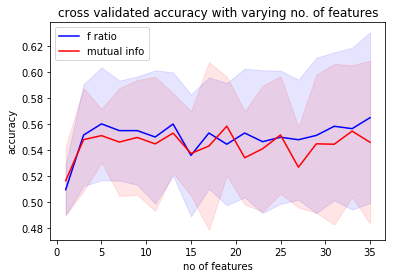

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
results_f = list()
std_f = list()
results_mi = list()
std_mi = list()
for i in range(1,37,2):
    pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
               ('select_feat',SelectKBest(k=i)),
                ('clf',LogisticRegression(C=100))])
    cv_scores = cross_val_score(pipe,X_train,y_train,cv=10,n_jobs=-1)
    results_f.append(cv_scores.mean())
    std_f.append(cv_scores.std())
    pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
               ('select_feat',SelectKBest(k=i,score_func = mutual_info_classif)),
                ('clf',LogisticRegression(C=100))])
    cv_scores = cross_val_score(pipe,X_train,y_train,cv=10,n_jobs=-1)
    results_mi.append(cv_scores.mean())
    std_mi.append(cv_scores.std())
    
results_mi,std_mi,results_f,std_f = np.array(results_mi),np.array(std_mi),np.array(results_f),np.array(std_f)    
plt.plot(range(1,37,2),results_f,c='b',label='f ratio')
plt.fill_between(range(1,37,2),results_f-std_f,results_f+std_f,alpha = .1,color='b')
plt.plot(range(1,37,2),results_mi,c='r',label = 'mutual info')
plt.fill_between(range(1,37,2),results_mi-std_mi,results_mi+std_mi,alpha=.1,color='r')
plt.legend(loc='upper left')
plt.xlabel('no of features')
plt.ylabel('accuracy')
plt.title('cross validated accuracy with varying no. of features')
plt.show()

As we can see, the accuracy is about the same using the mutal information, and the accuracy stops increasing soon after reaching approximately 5 features.  

C:\Users\Michael\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


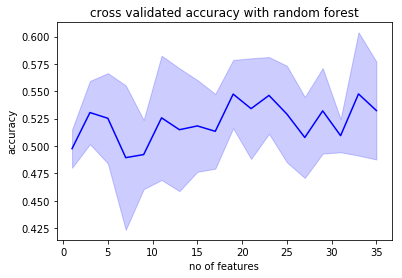

In [14]:
from sklearn.ensemble import RandomForestClassifier
results = list()
std = list()
for i in range(1,37,2):
    pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
               ('select_feat',SelectKBest(k=i)),
                ('clf',RandomForestClassifier())])
    cv_scores = cross_val_score(pipe,X_train,y_train,cv=10,n_jobs=-1)
    results.append(cv_scores.mean())
    std.append(cv_scores.std())
    
results, std = np.array(results),np.array(std)
plt.plot(range(1,37,2),results,c='b')
plt.fill_between(range(1,37,2),results-std,results+std,alpha = .2,color='b')
plt.legend(loc='upper left')
plt.xlabel('no of features')
plt.ylabel('accuracy')
plt.title('cross validated accuracy with random forest')
plt.show()

### Choosing a classifier.   <a id='4.2'></a>
There are several types of classifiers available in sklearn to use.   We have already tried LogisticRegression and Random Forests.  However, we have not find the optimal parameters for these models using a grid search yet.   To do this, we will use a grid search to evaluate all possible combinations.   We will test out three popular models for fitting categorical data, logistic regression, random forests, and support vector machines using both the linear and rbf kernel.   

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
               ('select_feat',SelectKBest(k=10)),
                ('clf',RandomForestClassifier())])
params = {'select_feat__k':range(6,14,2),'clf__min_samples_leaf':[1,5,10,15,20,25,50]}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
rf_est = grid_search.best_estimator_
print('Random forest Classifier')
print(grid_search.best_params_)
print('accuracy: {:.3f}'.format(grid_search.best_score_))
pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
                 ('scl',StandardScaler()),
               ('select_feat',SelectKBest(k=10)),
                ('clf',LogisticRegression())])
params = {'select_feat__k':range(10,20,2),'clf__C':[10**x for x in range(-3,5)]}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
lr_est = grid_search.best_estimator_
print('Logistic Regression')
print(grid_search.best_params_)
print('accuracy: {:.3f}'.format(grid_search.best_score_))

pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
                 ('scl',StandardScaler()),
               ('select_feat',SelectKBest(k=10)),
                ('clf',LinearSVC(class_weight='balanced',tol=.1))])
params = {'select_feat__k':range(10,20,2),'clf__C':[10**x for x in range(-3,5)]}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
lin_svm_est = grid_search.best_estimator_
print('Linear SVM')
print(grid_search.best_params_)
print('accuracy: {:.3f}'.format(grid_search.best_score_))

pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
                 ('scl',StandardScaler()),
               ('select_feat',SelectKBest(k=10)),
                ('clf',SVC())])
params = {'select_feat__k':range(10,20,2),
          'clf__kernel':['rbf'],
          'clf__C':[2**x for x in range(-5,16,2)],
          'clf__gamma':[2**x for x in range(-15,4,2)],
          'clf__class_weight':['balanced']}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
params = {'select_feat__k':[grid_search.best_params_['select_feat__k']],
          'clf__kernel':['rbf'],
          'clf__C':[grid_search.best_params_['clf__C']*(2**x) for x in np.arange(-1.5,1.75,.25)],
          'clf__gamma':[grid_search.best_params_['clf__gamma']*(2**x) for x in np.arange(-1.5,1.75,.25)],
          'clf__class_weight':['balanced']}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
svm_est = grid_search.best_estimator_
print('Kernel Support Vector Machine')
print(grid_search.best_params_)
print('accuracy: {:.3f}'.format(grid_search.best_score_))

Random forest Classifier
{'clf__min_samples_leaf': 15, 'select_feat__k': 6}
accuracy: 0.568
Logistic Regression
{'clf__C': 0.01, 'select_feat__k': 16}
accuracy: 0.572
Linear SVM
{'clf__C': 0.001, 'select_feat__k': 14}
accuracy: 0.542
Kernel Support Vector Machine
{'clf__class_weight': 'balanced', 'clf__C': 19.027313840043536, 'clf__gamma': 0.29730177875068026, 'select_feat__k': 14, 'clf__kernel': 'rbf'}
accuracy: 0.541


Another possible useful classifier is the gradient boosting classifier, XGBoost, which has been used to win several kaggle challenges.  Lets try it out on this dataset.    

In [19]:
from xgboost import XGBClassifier
pipe = Pipeline([('Imputer',Imputer(missing_values='NaN',strategy='mean',axis=0)),
               ('select_feat',SelectKBest(k=10)),
                ('clf',XGBClassifier(max_depth=4))])
params = {'select_feat__k':range(6,12,2),
          'clf__max_depth':range(3,8,1),
           'clf__subsample':np.arange(.5,1,.1),
           'clf__colsample_bytree':np.arange(.5,1,.1),
           'clf__reg_lambda':[10**x for x in range(-3,3)]}
grid_search = GridSearchCV(pipe,param_grid=params,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
xgb_est =grid_search.best_estimator_

{'clf__colsample_bytree': 0.89999999999999991, 'clf__max_depth': 6, 'clf__subsample': 0.59999999999999998, 'select_feat__k': 6, 'clf__reg_lambda': 100}
0.575129533679


We see here that xgboost does better slightly better then the random forest and logistic regression, however the results are all close to each other.  

## Results.   <a id='3'></a>

Upon applying our model to the testing dataset, we manage to get an accuracy of 56.7%.  The xgboost is only marginally more accurate then using a logistic regression in predicting the presence and type of heart disease.         

In [32]:
print("Testing accuracy for XGB classifier: {:.3f}".format(xgb_est.score(X_test,y_test)))

Testing accuracy for XGB classifier: 0.567


In [24]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

Several groups analyzing this dataset used a subsample of 14 features.  When we compare the features we use, we see that our algorithem already selected only from these 14 features, and ended up only selecting 6 of them to create the model (note cp_2 and cp_4 are one hot encodings of the values of the feature cp)

|Used in other Analysis|Selected by mutual_info|
|------------------------|------------------------ |
|age|relrest |
|sex| cp_2 |
|cp| cp_4 |
|trestbps| painexer |
|chol|  exang |
|fbs| relrest |
|restecg| |
|thalach|  |
|exang|   |
|oldpeak|  |
|slope| |
|ca| |
|thal| | 
|num | num | 

In [28]:
print(pd.Series(df.columns.difference(['num']))[xgb_est.named_steps['select_feat'].get_support()])
print(xgb_est.named_steps['clf'].feature_importances_)

4         cp_2
6         cp_4
9        exang
15     oldpeak
16    painexer
20     relrest
dtype: object
[ 0.04467465  0.08255099  0.15409517  0.49692458  0.11362901  0.1081256 ]


## Conclusions: <a id='4'></a>

In predicting the presence and type of heart desease, we were able to achieve a 57.5% accuracy on the training set, and a 56.7% accuracy on the test set, indicating that our model was not overfitting the data.     The most important features we found in predicting the presense of heart damage and the importance scores calculated by the xgboost classifier were:

|feature| importance|explanation |
|-------|-----------|------------|
|oldpeak | .497 | the ST depression induced by excercise compared to rest |
|exang| .154 | whether there was exercise induced angina |
| painexer| .114 | whether or not the pain was induced by exercise |
| relrest | .108 | whether or not the pain was relieved by rest |
| cp_4| .083  | presence of one type of chest pain |
|cp_2 | .045 | presence of another type of chest pain |
